# Extract MILC output
- Dec 28, 2021

## Description of columns in parse script : 



- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err

In [1]:
import os, glob
import subprocess as sp
import numpy as np
import shutil

import re

import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import *

import itertools

In [2]:
%matplotlib widget

In [78]:
top_dir='/gpfs/alpine/lgt104/proj-shared/ayyar/runs_frontier/runs_jan27_2023'

op_dict={
'cg_old_summit':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/parse_timings/output-cg.kpp',
'cg_new_summit':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/cg_run/output-full-cg_72nodes.kpp',

'mg_summit_old_drp':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-drop-xfast-1536vec-run-1.kpp',

'mg_summit_old':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-xfast-1536vec-run-1.kpp',

'new_mg_summit':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/mg_run1/output-full-xfast-1536vec-run-2.kpp',

'old_crusher_sprec':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_crusher/runs_oct28_2022/run2_6222/output-full.kpp',

'frontier_sprec':top_dir+'/single_precision_run/output-full.kpp',
'frontier_2_hprec':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_frontier/runs_feb1_2023_new_milc_build/run_144_hp/output-full_1.kpp',

'new_crusher_1_hprec':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_crusher/runs_feb1_2023_mpich8.1.14/output-full-2.kpp',
'new_crusher_2_hprec':'/gpfs/alpine/lgt104/proj-shared/ayyar/runs_crusher/runs_feb2_2023_mpich8.1.12/output-full-2.kpp'
}

# list(op_dict.keys())
# list(op_dict.values())

In [128]:
# cmd='./parse.sh %s mg '%(fname1)
# op=sp.check_output(cmd,shell=True,text=True)

## New way in python
# cmd=['./parse.sh',' '+fname1,'mg', ' > op0.out']
# print(cmd)
# op=sp.run(cmd,check=True,capture_output=True,text=True).stdout


In [116]:
## Parse output files

op_files=[]
for count,fl in enumerate(list(op_dict.values())):
    op_file='op%s.out'%(count)
    run_type='cg' if count<2 else 'mg'   ## Assume first 2 runs are cg, rest mg ##!
    print(fl,run_type)
    cmd='./parse.sh %s %s > %s'%(fl,run_type,op_file)
    op=sp.check_output(cmd,shell=True,text=True)
    
    ## Run bash script to parse output
    # cmd=['./parse.sh',fl,run_type,' > op%s.out'%(count+1)]
    # op=sp.run(cmd,check=True,capture_output=True,text=True)
    
    print(cmd)
    print(op)
    ## Append output file names to list
    op_files.append(op_file)

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/parse_timings/output-cg.kpp cg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/parse_timings/output-cg.kpp cg > op0.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/cg_run/output-full-cg_72nodes.kpp cg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/cg_run/output-full-cg_72nodes.kpp cg > op1.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-drop-xfast-1536vec-run-1.kpp mg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-drop-xfast-1536vec-run-1.kpp mg > op2.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-xfast-1536vec-run-1.kpp mg
./parse.sh /gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_march14_2022/output-full-xfast-1536vec-run-1.kpp mg > op3.out

/gpfs/alpine/lgt104/proj-shared/ayyar/runs_summit/runs_feb3_2023/mg_run1/output-full-xfast-1536vec-run-2.kpp

In [124]:
names=list(op_dict.keys())

gpus=[0 for i in range(0,len(names))]
for count,i in enumerate(names):
    if count<2: gpus[count]=int(864/2)
    else: gpus[count]=864
    
df_data=pd.DataFrame([])

count=0
for op_file, name,gpu in zip(op_files,names,gpus):
    print(op_file,name)
    with open(op_file,'r') as f:
        lst=f.readlines()

    print(lst)
    dict_values={}
    dict_values['name']=name
    dict_values['gpus']=int(gpu)
    # Add masses
    keys=lst[0].rstrip('\n').split(' ')
    vals=lst[1].rstrip('\n').split(' ')

    # Add timings
    keys+=lst[2].rstrip('\n').split(' ')
    vals+=lst[3].rstrip('\n').split(' ')

    # Add values to dictionary
    for k,v in zip(keys,vals):
        dict_values[k]=np.float64(v)

    # df_data=df_data.append(dict_values,ignore_index=True)
    df_data=pd.concat([df_data,pd.DataFrame(dict_values,index=[count])])
    count+=1

cols=['name', 'gpus','startup', 'loading', 'mg-setup',
       'make/save-src', 'mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-01-10',
       'mass-11-20', 'solve-time','contractions', 'quda-total-time','summed-time', 'error',
       'milc-total-time']

df_data=df_data[cols].copy()

op0.out cg_old_summit
['mass-01-10 mass-11-20\n', '1.3709695999999999e+03 1.6527176299999996e+02\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '7.172779e+01 6.197862e+02 0 3.0724827259999997e+03 5.905079e+01 4.168595e+02 4.2399070059999995e+03 3275.602 4.263153e+03 2.324599400000079e+01\n']
op1.out cg_new_summit
['mass-01-10 mass-11-20\n', '1.4316558500000001e+03 2.7283350900000011e+02\n', 'startup loading mg-setup solve-time make/save-src contractions summed-time quda-total-time milc-total-time error\n', '7.996576e+01 6.072320e+02 0 3.4089787180000003e+03 2.587562e-01 4.092303e+02 4.5056655342000004e+03 3757.776 4.590010e+03 8.434446579999985e+01\n']
op2.out mg_summit_old_drp
['mass-01 mass-02 mass-03 mass-04-10 mass-11-20\n', '2.6410875600000004e+01 2.2684568500000001e+01 2.2347331499999999e+01 1.7282348500000001e+02 9.5581005849999983e+01\n', 'startup loading mg-setup solve-time make/save-src contractions su

In [127]:
df_data

,name,gpus,startup,loading,mg-setup,make/save-src,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,contractions,quda-total-time,summed-time,error,milc-total-time
0,cg_old_summit,432,71.72779,619.7862,0.00,59.050790,NaN,NaN,NaN,NaN,1370.96960,165.271763,3072.482726,416.8595,3275.602,4239.907006,23.245994,4263.153
1,cg_new_summit,432,79.96576,607.2320,0.00,0.258756,NaN,NaN,NaN,NaN,1431.65585,272.833509,3408.978718,409.2303,3757.776,4505.665534,84.344466,4590.010
2,mg_summit_old_drp,864,68.78589,219.8139,1321.48,80.249010,26.410876,22.684569,22.347331,172.823485,NaN,95.581006,679.694533,185.9288,2021.795,2555.952133,24.836867,2580.789
3,mg_summit_old,864,68.89721,183.6686,1573.23,82.030770,23.328819,20.972033,22.804720,169.685265,NaN,92.148932,657.879539,191.2514,2283.090,2756.957519,56.200481,2813.158
4,new_mg_summit,864,78.65395,217.6886,1593.85,82.630040,20.281821,16.588694,17.250298,172.063075,NaN,89.272249,630.912275,185.6358,2334.469,2789.370665,119.125335,2908.496
5,old_crusher_sprec,864,36.01626,276.8052,1649.71,49.803680,24.131117,20.409475,19.869829,108.183160,NaN,55.475276,456.137714,345.4838,2120.104,2813.956654,24.323346,2838.280
6,frontier_sprec,864,34.13885,727.4382,3973.91,55.397150,38.345998,23.473233,22.505254,155.153805,NaN,64.920750,608.798078,373.6519,4715.879,5773.334178,76.763822,5850.098
7,frontier_2_hprec,864,35.53873,909.4658,3939.50,72.236460,25.740249,19.701767,19.965543,154.642155,NaN,66.345157,572.789743,376.9790,4647.040,5906.509733,79.666267,5986.176
8,new_crusher_1_hprec,864,36.33260,805.0354,4004.00,62.716700,24.788422,18.782316,20.262372,150.992310,NaN,63.855949,557.362739,423.3316,4696.898,5888.779039,83.878961,5972.658
9,new_crusher_2_hprec,864,48.23773,822.7423,4040.29,73.978930,26.333695,20.974092,21.218190,148.638410,NaN,66.783495,567.895762,417.2004,4744.151,5970.345122,83.552878,6053.898




- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err




In [126]:
df=df_data.copy()
nmax=max(df.gpus.values)
df['gpu_factor']=df.apply(lambda row: row.gpus/nmax, axis=1)

times_lst=['mass-01', 'mass-02', 'mass-03', 'mass-04-10',
       'mass-11-20', 'startup', 'loading', 'mg-setup', 'solve-time',
       'make/save-src', 'contractions', 'quda-total-time','summed-time', 'error',
       'milc-total-time']

# for col in times_lst:
    # df[col]=df[col]*df['gpu_factor']
    
df[:]

,name,gpus,startup,loading,mg-setup,make/save-src,mass-01,mass-02,mass-03,mass-04-10,mass-01-10,mass-11-20,solve-time,contractions,quda-total-time,summed-time,error,milc-total-time,gpu_factor
0,cg_old_summit,432,71.72779,619.7862,0.00,59.050790,NaN,NaN,NaN,NaN,1370.96960,165.271763,3072.482726,416.8595,3275.602,4239.907006,23.245994,4263.153,0.5
1,cg_new_summit,432,79.96576,607.2320,0.00,0.258756,NaN,NaN,NaN,NaN,1431.65585,272.833509,3408.978718,409.2303,3757.776,4505.665534,84.344466,4590.010,0.5
2,mg_summit_old_drp,864,68.78589,219.8139,1321.48,80.249010,26.410876,22.684569,22.347331,172.823485,NaN,95.581006,679.694533,185.9288,2021.795,2555.952133,24.836867,2580.789,1.0
3,mg_summit_old,864,68.89721,183.6686,1573.23,82.030770,23.328819,20.972033,22.804720,169.685265,NaN,92.148932,657.879539,191.2514,2283.090,2756.957519,56.200481,2813.158,1.0
4,new_mg_summit,864,78.65395,217.6886,1593.85,82.630040,20.281821,16.588694,17.250298,172.063075,NaN,89.272249,630.912275,185.6358,2334.469,2789.370665,119.125335,2908.496,1.0
5,old_crusher_sprec,864,36.01626,276.8052,1649.71,49.803680,24.131117,20.409475,19.869829,108.183160,NaN,55.475276,456.137714,345.4838,2120.104,2813.956654,24.323346,2838.280,1.0
6,frontier_sprec,864,34.13885,727.4382,3973.91,55.397150,38.345998,23.473233,22.505254,155.153805,NaN,64.920750,608.798078,373.6519,4715.879,5773.334178,76.763822,5850.098,1.0
7,frontier_2_hprec,864,35.53873,909.4658,3939.50,72.236460,25.740249,19.701767,19.965543,154.642155,NaN,66.345157,572.789743,376.9790,4647.040,5906.509733,79.666267,5986.176,1.0
8,new_crusher_1_hprec,864,36.33260,805.0354,4004.00,62.716700,24.788422,18.782316,20.262372,150.992310,NaN,63.855949,557.362739,423.3316,4696.898,5888.779039,83.878961,5972.658,1.0
9,new_crusher_2_hprec,864,48.23773,822.7423,4040.29,73.978930,26.333695,20.974092,21.218190,148.638410,NaN,66.783495,567.895762,417.2004,4744.151,5970.345122,83.552878,6053.898,1.0


In [120]:
sub_list=['name','mg-setup','solve-time','milc-total-time']
df[sub_list]

,name,mg-setup,solve-time,milc-total-time
0,cg_old_summit,0.00,3072.482726,4263.153
1,cg_new_summit,0.00,3408.978718,4590.010
2,mg_summit_old_drp,1321.48,679.694533,2580.789
3,mg_summit_old,1573.23,657.879539,2813.158
4,new_mg_summit,1593.85,630.912275,2908.496
5,old_crusher_sprec,1649.71,456.137714,2838.280
6,frontier_sprec,3973.91,608.798078,5850.098
7,frontier_2_hprec,3939.50,572.789743,5986.176
8,new_crusher_1_hprec,4004.00,557.362739,5972.658
9,new_crusher_2_hprec,4040.29,567.895762,6053.898


## Plots

,name,summed-time
0,cg_old_summit,4239.907006
1,cg_new_summit,4505.665534
2,mg_summit_old_drp,2555.952133
3,mg_summit_old,2756.957519
4,new_mg_summit,2789.370665
5,old_crusher_sprec,2813.956654
6,frontier_sprec,5773.334178
7,frontier_2_hprec,5906.509733
8,new_crusher_1_hprec,5888.779039
9,new_crusher_2_hprec,5970.345122


['cg_old_summit' 'cg_new_summit' 'mg_summit_old_drp' 'mg_summit_old'
 'new_mg_summit' 'old_crusher_sprec' 'frontier_sprec' 'frontier_2_hprec'
 'new_crusher_1_hprec' 'new_crusher_2_hprec'] [4239.907006  4505.6655342 2555.9521329 2756.957519  2789.3706652
 2813.9566538 5773.3341778 5906.5097327 5888.7790388 5970.3451224]


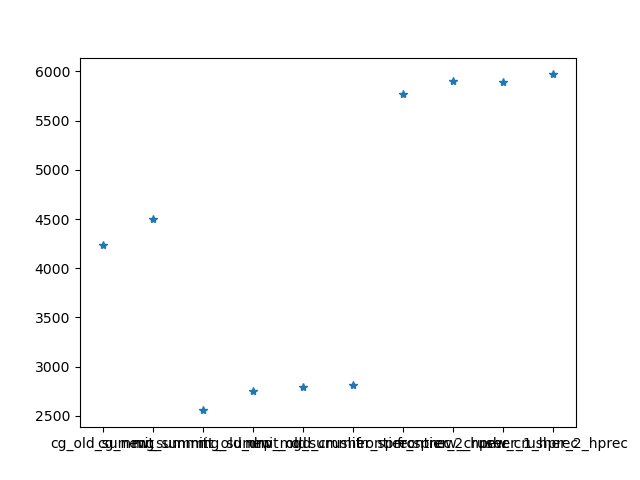

In [121]:
y_options=['mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-11-20',
       'startup', 'loading', 'mg-setup', 'solve-time', 'make/save-src',
       'contractions', 'summed-time', 'quda-total-time', 'milc-total-time',
       'error', 'mass-01-10']


def f_compare_plot(df,y,x='name'):
    # df.plot(x=x,y=y,kind='line',marker='D')
    
    display(df[[x,y]])
    
    x=df.name.values
    y=df[y].values
    print(x,y)
    plt.figure()
    plt.plot(x,y,marker='*',linestyle='')
    # plt.plot(y,marker='*')
    # plt.legend()
    plt.show()
    
# df.plot(x='name',y='summed-time',kind='line',marker='*')
f_compare_plot(df,'summed-time','name')

In [38]:
interact(f_compare_plot,df=fixed(df),y=y_options,x=fixed('name'))

interactive(children=(Dropdown(description='y', options=('mass-01', 'mass-02', 'mass-03', 'mass-04-10', 'mass-…

<function __main__.f_compare_plot(df, y, x='name')>

In [130]:
def f_plot_together(df,labels_lst,markers_lst): 
    plt.figure()
    x=df.name.values

    for label,marker in zip(labels_lst,markers_lst):
        y=df[label].values
        plt.plot(x,y,marker=marker,label=label)

    plt.legend()


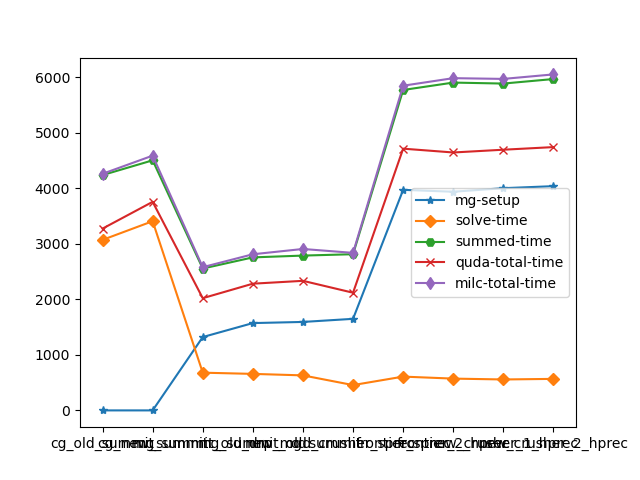

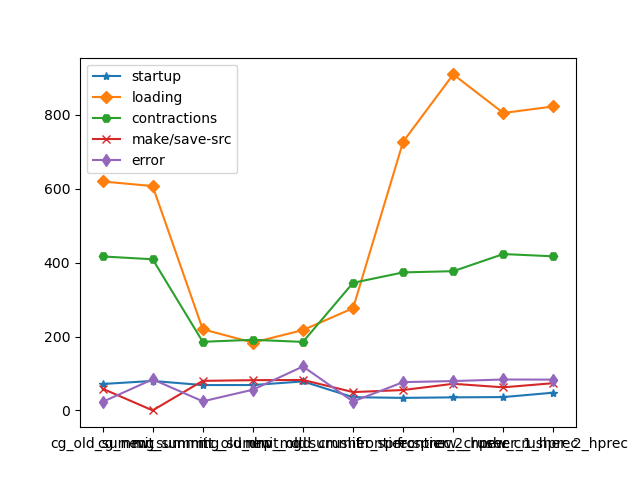

In [131]:
markers=['*','D','H','x','d','p','1','2','h','v']
labels=['startup', 'loading', 'mg-setup', 'solve-time', 'make/save-src',
       'contractions', 'summed-time', 'quda-total-time', 'milc-total-time',
       'error']

labels1=['mg-setup', 'solve-time','summed-time', 'quda-total-time', 'milc-total-time']

labels2=['startup', 'loading','contractions','make/save-src','error']

f_plot_together(df,labels1,markers)
f_plot_together(df,labels2,markers)


In [12]:
pwd

'/autofs/nccs-svm1_home1/venkitesh/projects/lqcd/multigrid_lattice/Staggered_multigrid_build/analysis_notebooks/data_extraction'